In [1]:
import pandas as pd
import numpy as np
import sys
from sklearn.model_selection import train_test_split
import GPUtil
import itertools
import pickle
from datetime import datetime
import os
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
import torch.nn as nn
from sklearn.preprocessing import Normalizer
import joblib
import ili  # Import ili for the SBI functionality
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior


import warnings  # noqa
warnings.filterwarnings('ignore')  # noqa

import numpy as np
from numpy import testing
import matplotlib.pyplot as plt
import torch
import os
import yaml
from pathlib import Path
import xarray as xr
import csv
import json
import unittest

import ili
from ili.dataloaders import (
    NumpyLoader, SBISimulator, StaticNumpyLoader, SummarizerDatasetLoader,
    TorchLoader)
from ili.inference import (
    SBIRunner, SBIRunnerSequential, ABCRunner, InferenceRunner)
from ili.validation.metrics import (
    PlotSinglePosterior, PosteriorCoverage, PosteriorSamples)
from ili.validation.runner import ValidationRunner
from ili.embedding import FCN
from ili.utils import load_nde_sbi



from sbi.utils.user_input_checks import process_prior

sys.path.append("/disk/xray15/aem2/camels/proj2")
from setup_params_1P import plot_uvlf, plot_colour
from setup_params_SB import *
# from setup_params import *
from priors_SB import initialise_priors_SB28
from variables_config_28 import uvlf_limits, n_bins_lf, colour_limits, n_bins_colour


In [2]:
# parameters
device = "cuda" if torch.cuda.is_available() else "cpu"
model = "IllustrisTNG"
spec_type = "attenuated"
sps = "BC03"
snap = ["044"]
bands = "all" # or just GALEX?

colours = False  
luminosity_functions = True
name = f"{model}_{bands}_{sps}_{spec_type}_{n_bins_lf}_{n_bins_colour}"

cam = camels(model=model, sim_set='SB28')

if colours and not luminosity_functions:
    model_out_dir = "/disk/xray15/aem2/data/28pams/IllustrisTNG/SB/models/colours_only/"
    plots_out_dir = "/disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/sbi_plots/colours_only/"
    
elif luminosity_functions and not colours:
    model_out_dir = "/disk/xray15/aem2/data/28pams/IllustrisTNG/SB/models/lf_only/"
    plots_out_dir = "/disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/sbi_plots/lfs_only/"

elif colours and luminosity_functions:
    model_out_dir = "/disk/xray15/aem2/data/28pams/IllustrisTNG/SB/models/colours_lfs/"
    plots_out_dir = "/disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/sbi_plots/colours_lfs/"

else:
    raise ValueError("At least one of colours or luminosity_functions must be True")

print("Saving model in ", model_out_dir)
print("Saving plots in ", plots_out_dir)



Saving model in  /disk/xray15/aem2/data/28pams/IllustrisTNG/SB/models/lf_only/
Saving plots in  /disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/sbi_plots/lfs_only/


In [3]:
import pandas as pd
import numpy as np
import sys
import GPUtil  # You already have this imported
import torch
# Add these imports at the top with your other imports
import os
from pynvml import *

# Add this function at the start, before any GPU operations
def select_least_used_gpu():
    try:
        # Initialize NVIDIA management library
        nvmlInit()
        
        # Get number of GPUs
        deviceCount = nvmlDeviceGetCount()
        gpu_memory_used = []
        
        # Check memory usage for each GPU
        for i in range(deviceCount):
            handle = nvmlDeviceGetHandleByIndex(i)
            info = nvmlDeviceGetMemoryInfo(handle)
            gpu_memory_used.append((i, info.used))
        
        # Sort by memory usage and get GPU with least memory used
        least_used_gpu = sorted(gpu_memory_used, key=lambda x: x[1])[0][0]
        
        # Set CUDA device
        torch.cuda.set_device(least_used_gpu)
        print(f"Selected GPU {least_used_gpu} with {gpu_memory_used[least_used_gpu][1]/1024**2:.0f}MB used")
        
        return least_used_gpu
    
    except Exception as e:
        print(f"Error selecting GPU: {e}")
        return 0  # Default to first GPU if there's an error

# Add this right after your imports, before any GPU operations
# Select GPU and set device
gpu_id = select_least_used_gpu()
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)
device = torch.device(f"cuda:{gpu_id}" if torch.cuda.is_available() else "cpu")

# The rest of your code remains the same, but remove or comment out your original device line:
# device = "cuda" if torch.cuda.is_available() else "cpu"

Selected GPU 2 with 637MB used


In [5]:
# First, let's check what type of data we have
def convert_to_numpy(data):
    """
    Safely converts data to numpy array regardless of whether it's a torch tensor or numpy array
    
    Parameters:
        data: Input data (either torch.Tensor or numpy.ndarray)
    
    Returns:
        numpy.ndarray: The data converted to numpy array
    """
    if torch.is_tensor(data):
        # If it's a torch tensor, move to CPU and convert to numpy
        return data.cpu().numpy()
    elif isinstance(data, np.ndarray):
        # If it's already a numpy array, return as is
        return data
    else:
        # If it's neither, try converting to numpy array
        return np.array(data)


In [6]:
print(uvlf_limits)

(-25, -14)


In [7]:

# parameter info file (df_info) is used for defining priors
# the actual parameter values come from the camels class which reads CosmoAstroSeed_IllustrisTNG_L25n256_SB28.txt

#  parameters defined here: /disk/xray15/aem2/data/28pams/IllustrisTNG/SB/CosmoAstroSeed_IllustrisTNG_L25n256_SB28.txt which is used for theta
df_pars = pd.read_csv('/disk/xray15/aem2/data/28pams/IllustrisTNG/SB/CosmoAstroSeed_IllustrisTNG_L25n256_SB28.txt', delim_whitespace=True)
print(df_pars)


          #Name    Omega0    sigma8  WindEnergyIn1e51erg  RadioFeedbackFactor  \
0        SB28_0  0.352541  0.694742              3.85743             1.519210   
1        SB28_1  0.172430  0.830154              1.03554             0.797734   
2        SB28_2  0.234683  0.705844              9.61416             3.380650   
3        SB28_3  0.440288  0.969259              2.14363             0.488165   
4        SB28_4  0.457152  0.786733              1.38466             0.325727   
...         ...       ...       ...                  ...                  ...   
2043  SB28_2043  0.457334  0.970226              8.89733             0.607197   
2044  SB28_2044  0.440496  0.786137              5.34131             0.880840   
2045  SB28_2045  0.234475  0.938760              1.49723             1.873430   
2046  SB28_2046  0.172613  0.612888             13.31250             0.363806   
2047  SB28_2047  0.352358  0.862216              3.09935             3.331570   

      VariableWindVelFactor

In [8]:
df_pars

,#Name,Omega0,sigma8,WindEnergyIn1e51erg,RadioFeedbackFactor,VariableWindVelFactor,RadioFeedbackReiorientationFactor,OmegaBaryon,HubbleParam,n_s,...,WindEnergyReductionExponent,WindDumpFactor,SeedBlackHoleMass,BlackHoleAccretionFactor,BlackHoleEddingtonFactor,BlackHoleFeedbackFactor,BlackHoleRadiativeEfficiency,QuasarThreshold,QuasarThresholdPower,seed
0,SB28_0,0.352541,0.694742,3.85743,1.519210,9.09267,14.2845,0.049404,0.498145,0.795765,...,1.61148,0.435971,0.000069,1.111740,2.613460,0.039463,0.225386,0.000269,0.514648,20000
1,SB28_1,0.172430,0.830154,1.03554,0.797734,6.95693,38.2374,0.031199,0.683693,1.142160,...,2.08951,0.612056,0.000094,0.889955,0.302262,0.151352,0.086231,0.022802,2.620780,20001
2,SB28_2,0.234683,0.705844,9.61416,3.380650,3.77681,24.6592,0.042995,0.849506,0.923545,...,1.33988,0.878906,0.000153,0.364219,8.235920,0.099772,0.648096,0.001458,3.389560,20002
3,SB28_3,0.440288,0.969259,2.14363,0.488165,11.49660,10.9550,0.062295,0.638970,0.964648,...,2.86478,0.253435,0.000041,2.775960,0.950425,0.349945,0.126670,0.004242,1.494400,20003
4,SB28_4,0.457152,0.786733,1.38466,0.325727,13.19410,17.1439,0.044425,0.773770,0.900256,...,2.59030,0.944457,0.000049,0.286789,1.121900,0.032352,0.460414,0.007438,2.299550,20004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,SB28_2043,0.457334,0.970226,8.89733,0.607197,3.75653,39.5139,0.046041,0.513293,0.828903,...,1.88784,0.725070,0.000054,0.327481,4.790910,0.033553,0.481742,0.001252,2.191720,22043
2044,SB28_2044,0.440496,0.786137,5.34131,0.880840,5.04789,21.6844,0.063161,0.748997,1.143290,...,1.66098,0.472330,0.000038,2.229260,0.222157,0.397001,0.109068,0.000416,1.012360,22044
2045,SB28_2045,0.234475,0.938760,1.49723,1.873430,13.26680,13.5869,0.042461,0.534548,0.796116,...,2.13803,0.698393,0.000174,0.453541,1.920250,0.087029,0.682619,0.006263,3.117210,22045
2046,SB28_2046,0.172613,0.612888,13.31250,0.363806,8.64069,17.7159,0.029257,0.600362,0.965127,...,1.38572,0.818457,0.000090,0.718570,0.698528,0.158683,0.083655,0.000071,2.887940,22046


In [9]:

df_pars = df_pars.iloc[:, 0:7] # Remember that Python does not slice inclusive of the ending index.
df_pars


,#Name,Omega0,sigma8,WindEnergyIn1e51erg,RadioFeedbackFactor,VariableWindVelFactor,RadioFeedbackReiorientationFactor
0,SB28_0,0.352541,0.694742,3.85743,1.519210,9.09267,14.2845
1,SB28_1,0.172430,0.830154,1.03554,0.797734,6.95693,38.2374
2,SB28_2,0.234683,0.705844,9.61416,3.380650,3.77681,24.6592
3,SB28_3,0.440288,0.969259,2.14363,0.488165,11.49660,10.9550
4,SB28_4,0.457152,0.786733,1.38466,0.325727,13.19410,17.1439
...,...,...,...,...,...,...,...
2043,SB28_2043,0.457334,0.970226,8.89733,0.607197,3.75653,39.5139
2044,SB28_2044,0.440496,0.786137,5.34131,0.880840,5.04789,21.6844
2045,SB28_2045,0.234475,0.938760,1.49723,1.873430,13.26680,13.5869
2046,SB28_2046,0.172613,0.612888,13.31250,0.363806,8.64069,17.7159


In [10]:
no_pams = 6
end_of_pams = no_pams + 1 
param_names = df_pars.columns[1:end_of_pams].tolist()  # Excluding 'name' column
param_length = len(param_names)


param_length


6

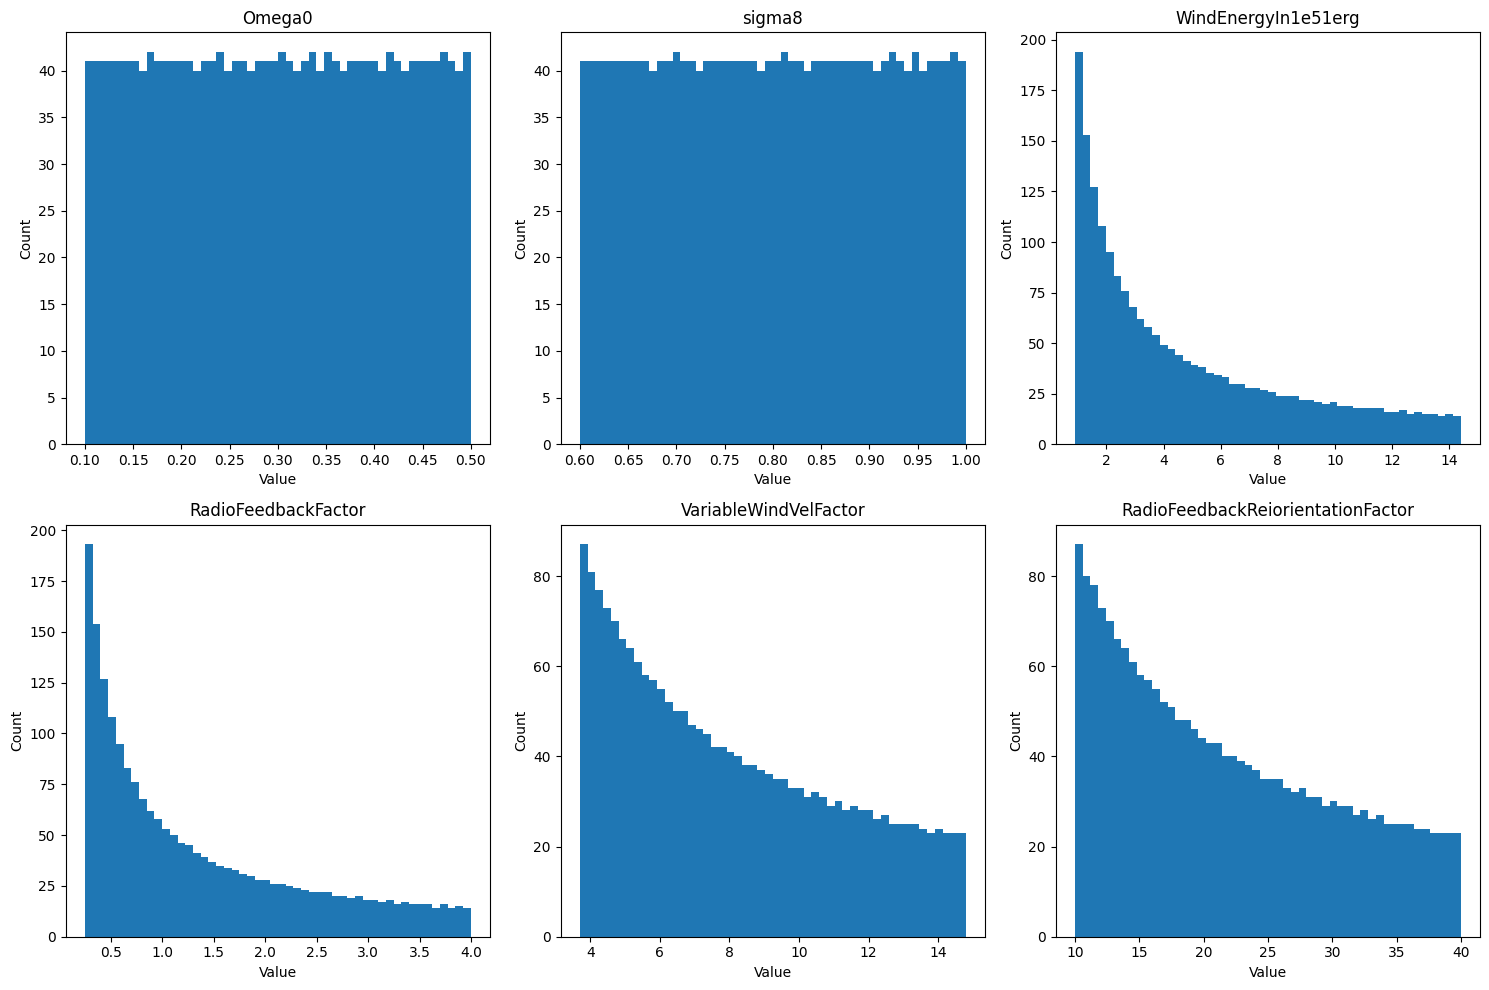

In [11]:
theta_lst = df_pars.iloc[:, 1:end_of_pams].to_numpy()  # excluding 'name' column and 'seed' column

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, param_name in enumerate(param_names):
    axes[i].hist(theta_lst[:, i], bins=50)
    axes[i].set_title(param_name)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()


In [12]:


# prior values come from this:
df_info = pd.read_csv("/disk/xray15/aem2/data/28pams/Info_IllustrisTNG_L25n256_28params.txt")
print(df_info)


                            ParamName  AbsMaxDiff  LogFlag  FiducialVal  \
0                              Omega0        0.20        0      0.30000   
1                              sigma8        0.20        0      0.80000   
2                 WindEnergyIn1e51erg        4.00        1      3.60000   
3                 RadioFeedbackFactor        4.00        1      1.00000   
4               VariableWindVelFactor        2.00        1      7.40000   
5   RadioFeedbackReiorientationFactor        2.00        1     20.00000   
6                         OmegaBaryon        0.02        0      0.04900   
7                         HubbleParam        0.20        0      0.67110   
8                                 n_s        0.20        0      0.96240   
9                     MaxSfrTimescale        2.00        1      2.27000   
10                 FactorForSofterEQS        3.00        1      0.30000   
11                           IMFslope        0.50        0     -2.30000   
12                  SNII_

In [13]:
df_info6 = df_info[0:6]
df_info6

,ParamName,AbsMaxDiff,LogFlag,FiducialVal,MinVal,MaxVal,Description
0,Omega0,0.2,0,0.3,0.10,0.5,OmegaMatter
1,sigma8,0.2,0,0.8,0.60,1.0,sigma8
2,WindEnergyIn1e51erg,4.0,1,3.6,0.90,14.4,ASN1 - galactic winds energy
3,RadioFeedbackFactor,4.0,1,1.0,0.25,4.0,AAGN1 - AGN FB kinetic mode energy
4,VariableWindVelFactor,2.0,1,7.4,3.70,14.8,ASN2 - galactic winds speed
5,RadioFeedbackReiorientationFactor,2.0,1,20.0,10.00,40.0,AAGN2 - AGN FB kinetic mode burstiness


torch.Size([2048, 6]) (2048, 24)


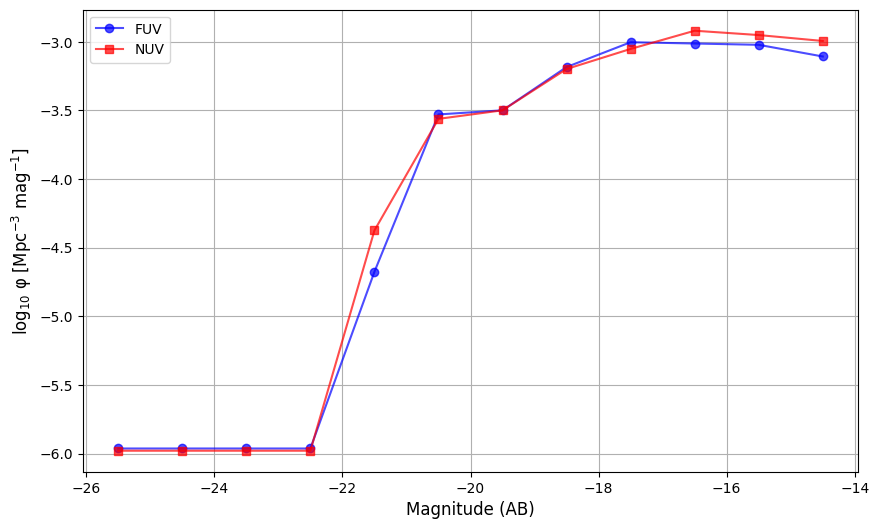

processing Omega0:
processing Omega0 is linear with min 0.1 and max 0.5:
processing sigma8:
processing sigma8 is linear with min 0.6 and max 1.0:
processing WindEnergyIn1e51erg:
processing WindEnergyIn1e51erg is logarithmic with min 0.9 and max 14.4:
processing RadioFeedbackFactor:
processing RadioFeedbackFactor is logarithmic with min 0.25 and max 4.0:
processing VariableWindVelFactor:
processing VariableWindVelFactor is logarithmic with min 3.7 and max 14.8:
processing RadioFeedbackReiorientationFactor:
processing RadioFeedbackReiorientationFactor is logarithmic with min 10.0 and max 40.0:
Theta shape: torch.Size([2048, 6])
X shape: torch.Size([2048, 24])
x_all: tensor([[-5.9627, -5.9627, -5.9627,  ..., -2.9198, -2.9514, -2.9944],
        [-5.9938, -5.9938, -5.9938,  ..., -2.5617, -2.4853, -2.3535],
        [-5.9621, -5.9621, -4.6757,  ..., -2.6586, -2.7463, -2.7463],
        ...,
        [-5.9631, -5.9631, -5.9631,  ..., -2.6188, -2.6934, -2.6303],
        [-5.9664, -5.9664, -5.9664

In [14]:
# overwrite theta with the real theta
if __name__ == "__main__":
    theta, x = get_theta_x_SB(
        luminosity_functions=luminosity_functions,
        colours=colours,
        uvlf_limits=uvlf_limits,
        colour_limits=colour_limits,
        n_bins_lf=n_bins_lf,
        n_bins_colour=n_bins_colour
    )
    print(theta.shape, x.shape)

if colours:
    fig = plot_colour(x)
    plt.savefig('/disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/colours_test/colour_check.png')
    plt.show()

if luminosity_functions:
    fig = plot_uvlf(x)
    plt.savefig('/disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/LFs_test/uvlf_check.png')
    plt.show()


# get the priors and data
prior = initialise_priors_SB28(
    df=df_info6, 
    device=device,
    astro=True,
    dust=False  # no dust for testing. set to False to only get the 28 model parameters.
    # with dust = True, prior has 32 dimensions (28 parameters + 4 dust parameters) 
)

# process the data
x_all = np.array([np.hstack(_x) for _x in x])
x_all = torch.tensor(x_all, dtype=torch.float32, device=device)

print("Theta shape:", theta.shape)
print("X shape:", x_all.shape)


# Move data to GPU as early as possible
x_all = x_all.to(device)
print('x_all:', x_all)

theta = torch.tensor(theta, dtype=torch.float32, device=device)
print('theta:', theta)

# Handle NaN values and normalize while on GPU
x_all_cpu = x_all.cpu().numpy()  # Only move to CPU when necessary for sklearn
print('x_all_cpu:', x_all_cpu)

print("Data shape before processing:", x_all_cpu.shape)
print("Number of values:",(x_all_cpu).sum())
print("Number of NaN values:", np.isnan(x_all_cpu).sum())
print("Number of infinite values:", np.isinf(x_all_cpu).sum())


# get rid of NaN/inf values, replace with small random noise
nan_mask = np.isnan(x_all_cpu) | np.isinf(x_all_cpu)
print('nan_mask:', nan_mask)


if nan_mask.any():
    x_all_cpu[nan_mask] = np.random.rand(np.sum(nan_mask)) * 1e-10

print("Data shape before processing:", x_all_cpu.shape)
print("Number of NaN values:", np.isnan(x_all_cpu).sum())
print("Number of infinite values:", np.isinf(x_all_cpu).sum())

print('x_all_cpu:', x_all_cpu)

# make test mask
test_mask = create_test_mask() # 10% testing
train_mask = ~test_mask # 90% for training



In [15]:
# # additional processing to solve cpu / cuda issues
# # we want it to be numpy before we put into the model and then put it into the model

# # # process the data
# x_all = np.array([np.hstack(_x) for _x in x])
# # x_all = torch.tensor(x_all, dtype=torch.float32, device=device)

# print("Theta shape:", theta.shape)
# print("X shape:", x_all.shape)


# # # # Move data to GPU as early as possible
# # x_all = x_all.to(device)
# # # print('x_all:', x_all)

# # theta = torch.tensor(theta, dtype=torch.float32, device=device)
# # # print('theta:', theta)

# # Handle NaN values and normalize while on GPU



If using only luminosity functions (LFs):

2 GALEX filters (FUV, NUV)
Each filter gets n_bins_lf (12) bins
2 filters * 12 bins = 24 features

If also using colors:

1 color (FUV-NUV)
Gets n_bins_colour (12) bins
Total would be 24 + 12 = 36 features

In [16]:

# print("Theta shape:", theta.shape)
# print("X shape:", x_all.shape)

In [15]:
from sklearn.preprocessing import StandardScaler

class GlobalScaler:
    def fit_transform(self, x):
        self._mean_x = x.mean()
        self._std_x = x.std()
        return (x - self._mean_x) / self._std_x

    def transform(self, x):
        return (x - self._mean_x) / self._std_x

    def inverse_transform(self, x_norm):
        return (x_norm * self._std_x) + self._mean_x


x_scaler = GlobalScaler()  # scales all features by same mean and std  over N samples
theta_scaler = StandardScaler()  # scales each feature by its own mean and std over N samples

# Convert theta tensors to numpy for scaling
# convert to numpy
x = convert_to_numpy(x)
theta = convert_to_numpy(theta)

print("Type of x:", type(x))
print("Type of theta:", type(theta))

# split into training and testing samples:

# make test mask
test_mask = create_test_mask() # 10% testing
train_mask = ~test_mask # 90% for training


# split data
x_train=x_all_cpu[train_mask]
theta_train=theta[train_mask]

x_test = x_all_cpu[test_mask]
theta_test = theta[test_mask]


# apply scaling /normalisation
x_train = x_scaler.fit_transform(x_train)
x_test = x_scaler.transform(x_train)
# theta_train_scaled = theta_scaler.fit_transform(theta_train_np)
# theta_test_scaled = theta_scaler.transform(theta_test_np)
theta_train = theta_scaler.fit_transform(theta_train)
theta_test = theta_scaler.transform(theta_test)


Type of x: <class 'numpy.ndarray'>
Type of theta: <class 'numpy.ndarray'>
Total simulations: 2048
Test set size: 203
Training set size: 1845
Test fraction: 0.099


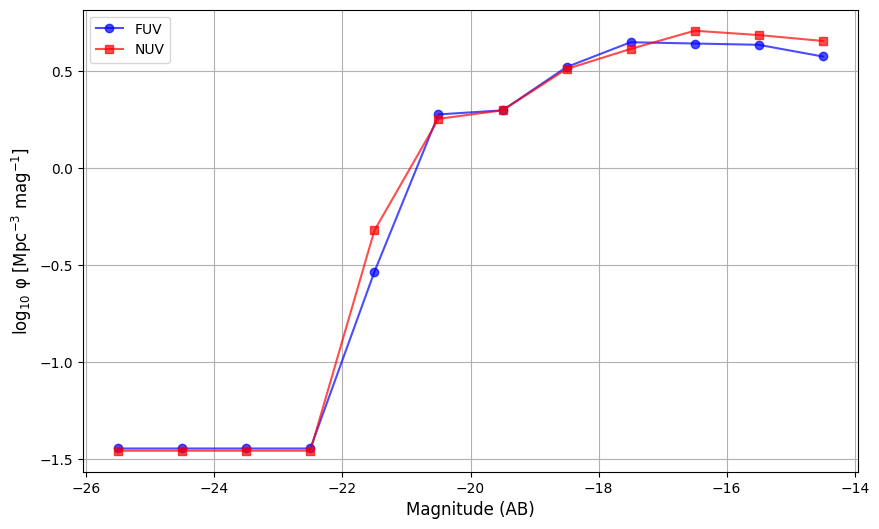

In [16]:
if colours:
    fig = plot_colour(x_train)
    plt.savefig('/disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/colours_test/colour_check.png')
    plt.show()

if luminosity_functions:
    fig = plot_uvlf(x_train)
    plt.savefig('/disk/xray15/aem2/plots/28pams/IllustrisTNG/SB/test/LFs_test/uvlf_check.png')
    plt.show()


In [17]:
print(type(x_train))
print(type(theta_train))
# print(x_train.device)  # Should print something like 'cuda:0' if on GPU
# print(theta_train.device)  # Should print something like 'cuda:0' if on GPU

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [18]:
# After scaling, convert to torch tensors with correct dtype
x_train = torch.tensor(x_train, dtype=torch.float32, device=device) 
theta_train = torch.tensor(theta_train, dtype=torch.float32, device=device)

In [19]:
print(type(x_train))
print(type(theta_train))
print(x_train.device)  # Should print something like 'cuda:0' if on GPU
print(theta_train.device)  # Should print something like 'cuda:0' if on GPU

<class 'torch.Tensor'>
<class 'torch.Tensor'>
cuda:2
cuda:2


Testing prior:


Prior samples shape: torch.Size([1000, 6])


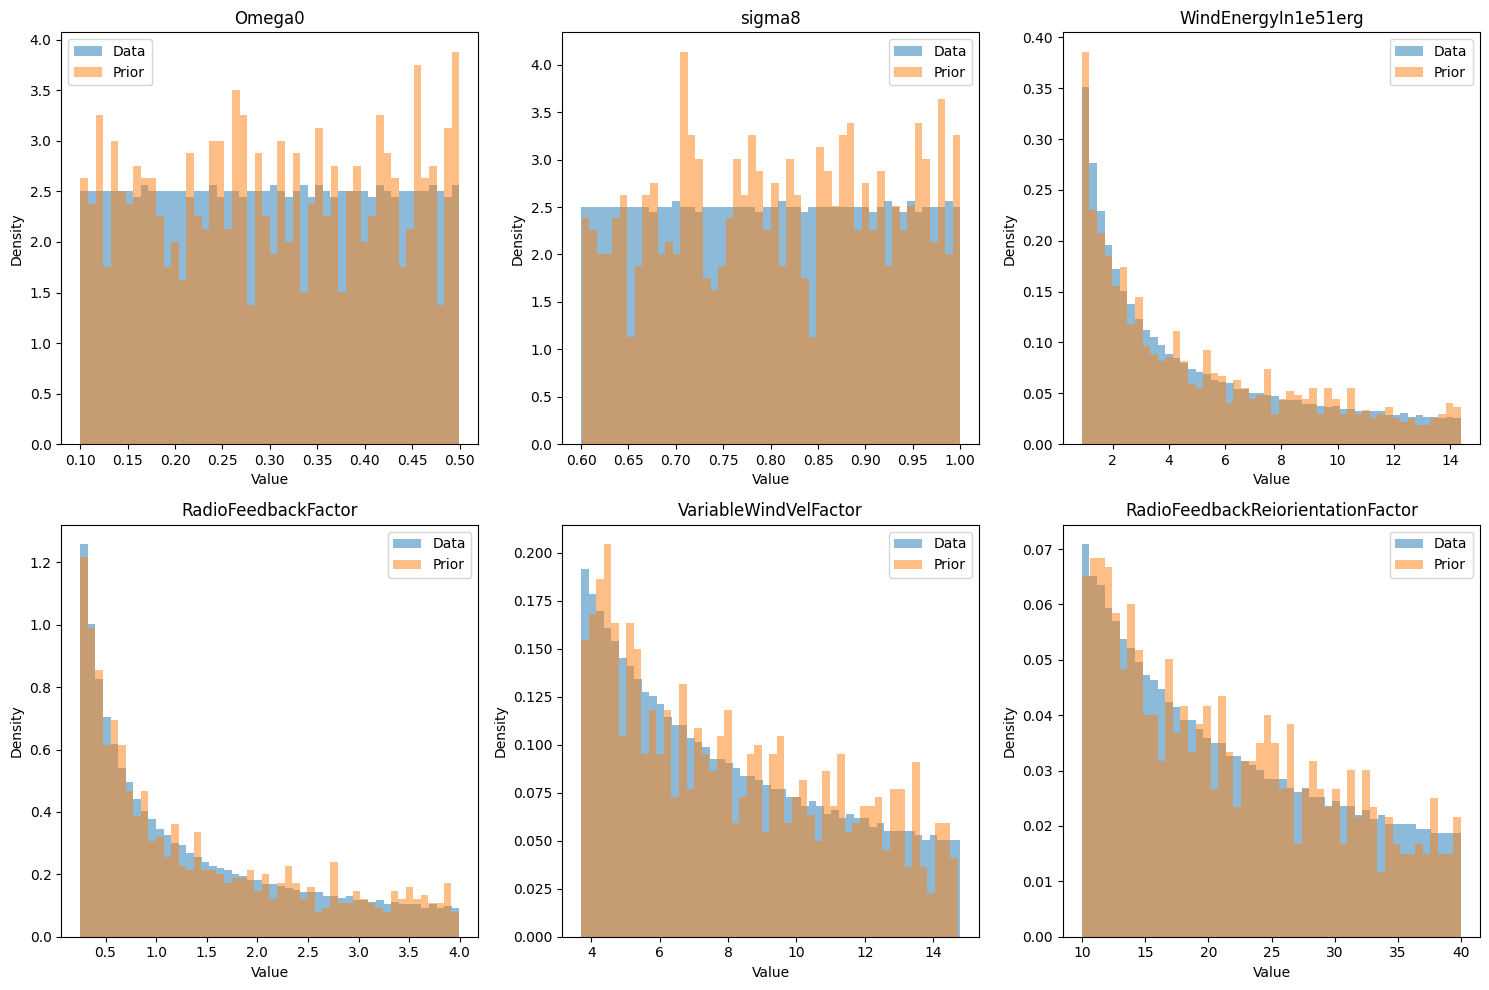


Parameter ranges:

Omega0:
Data range: [0.100, 0.500]
Prior range: [0.100, 0.500]

sigma8:
Data range: [0.600, 1.000]
Prior range: [0.601, 1.000]

WindEnergyIn1e51erg:
Data range: [0.900, 14.397]
Prior range: [0.900, 14.386]

RadioFeedbackFactor:
Data range: [0.250, 3.997]
Prior range: [0.250, 3.990]

VariableWindVelFactor:
Data range: [3.702, 14.791]
Prior range: [3.704, 14.716]

RadioFeedbackReiorientationFactor:
Data range: [10.001, 39.982]
Prior range: [10.006, 39.958]


In [39]:
# Add this after your prior definition
# Test prior sampling
n_samples = 1000
prior_samples = prior.sample((n_samples,))
print("Prior samples shape:", prior_samples.shape)

# Plot histograms of prior samples vs actual parameter values
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

prior_samples_np = prior_samples.cpu().numpy()

for i, param_name in enumerate(param_names):
    # Plot histogram of actual parameter values
    axes[i].hist(theta_lst[:, i], bins=50, alpha=0.5, label='Data', density=True)
    # Plot histogram of prior samples 
    axes[i].hist(prior_samples_np[:, i], bins=50, alpha=0.5, label='Prior', density=True)
    axes[i].set_title(param_name)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Density')
    axes[i].legend()

plt.tight_layout()
plt.show()

# Print ranges
print("\nParameter ranges:")
for i, param_name in enumerate(param_names):
    data_min = theta_lst[:, i].min()
    data_max = theta_lst[:, i].max()
    prior_min = prior_samples_np[:, i].min()
    prior_max = prior_samples_np[:, i].max()
    print(f"\n{param_name}:")
    print(f"Data range: [{data_min:.3f}, {data_max:.3f}]")
    print(f"Prior range: [{prior_min:.3f}, {prior_max:.3f}]")

In [40]:
# Test if parameters are within prior support
def check_prior_support(prior, theta):
    """Check if parameters are within prior support"""
    log_prob = prior.log_prob(theta)
    invalid_mask = torch.isinf(log_prob) | torch.isnan(log_prob)
    
    if invalid_mask.any():
        print("\nFound parameters outside prior support!")
        for i in range(theta.shape[1]):
            invalid_params = theta[invalid_mask, i]
            if len(invalid_params) > 0:
                print(f"\nParameter {param_names[i]}:")
                print(f"Invalid values: {invalid_params.cpu().numpy()}")
    else:
        print("\nAll parameters within prior support")
    
    return log_prob

# Convert theta to tensor if needed
if not torch.is_tensor(theta):
    theta = torch.tensor(theta, dtype=torch.float32)
theta = theta.to(device)

log_prob = check_prior_support(prior, theta)
print("\nLog probability range:", log_prob.min().item(), "to", log_prob.max().item())


All parameters within prior support

Log probability range: -10.674741744995117 to -3.7520081996917725


In [43]:
# Modified test for MultipleIndependent prior with correct column names
def test_prior_boundaries(prior, n_samples=1000):
    """Test if prior samples stay within expected boundaries"""
    # Sample from prior
    samples = prior.sample((n_samples,))
    samples_np = samples.cpu().numpy()
    
    print("\nPrior boundary test results:")
    for i, param_name in enumerate(param_names):
        param_samples = samples_np[:, i]
        expected_min = df_info6.iloc[i]['MinVal']  # Changed from 'min' to 'MinVal'
        expected_max = df_info6.iloc[i]['MaxVal']  # Changed from 'max' to 'MaxVal'
        
        actual_min = param_samples.min()
        actual_max = param_samples.max()
        
        within_bounds = (actual_min >= expected_min) and (actual_max <= expected_max)
        
        print(f"\n{param_name}:")
        print(f"Expected range: [{expected_min:.3f}, {expected_max:.3f}]")
        print(f"Actual range: [{actual_min:.3f}, {actual_max:.3f}]")
        print(f"Within bounds: {within_bounds}")
        
        # Additional check for log-transformed parameters
        is_log = df_info6.iloc[i]['LogFlag'] == 1
        if is_log:
            print(f"(Log-transformed parameter)")

# Run both tests
test_prior_boundaries(prior)

def test_prior_density(prior, n_samples=1000):
    """Test if prior probability density is reasonable"""
    samples = prior.sample((n_samples,))
    log_probs = prior.log_prob(samples)
    
    print("\nPrior density test results:")
    print(f"Mean log probability: {log_probs.mean().item():.3f}")
    print(f"Min log probability: {log_probs.min().item():.3f}")
    print(f"Max log probability: {log_probs.max().item():.3f}")
    
    # Check for any infinite or NaN values
    invalid_mask = torch.isinf(log_probs) | torch.isnan(log_probs)
    print(f"Number of invalid probabilities: {invalid_mask.sum().item()}")

test_prior_density(prior)


Prior boundary test results:

Omega0:
Expected range: [0.100, 0.500]
Actual range: [0.101, 0.499]
Within bounds: True

sigma8:
Expected range: [0.600, 1.000]
Actual range: [0.601, 1.000]
Within bounds: True

WindEnergyIn1e51erg:
Expected range: [0.900, 14.400]
Actual range: [0.902, 14.362]
Within bounds: True
(Log-transformed parameter)

RadioFeedbackFactor:
Expected range: [0.250, 4.000]
Actual range: [0.250, 3.986]
Within bounds: True
(Log-transformed parameter)

VariableWindVelFactor:
Expected range: [3.700, 14.800]
Actual range: [3.707, 14.793]
Within bounds: True
(Log-transformed parameter)

RadioFeedbackReiorientationFactor:
Expected range: [10.000, 40.000]
Actual range: [10.023, 39.978]
Within bounds: True
(Log-transformed parameter)

Prior density test results:
Mean log probability: -7.151
Min log probability: -10.731
Max log probability: -3.644
Number of invalid probabilities: 0


 
# ORIGINAL CODE in this cell, markdown as testing new device manuevers
<!--train_args = {
    "training_batch_size": 16,     # Slightly reduced
    "learning_rate": 1e-4,        # Original learning rate for fewer parameters
    "stop_after_epochs": 20,      # More patience
    "clip_max_norm": 2,        # Tight gradient control
     "validation_fraction": 0.1,    # More validation data
    "max_num_epochs": 200,       # Allow longer training
    "show_train_summary": True
}

# Slightly increased capacity for better learning of core parameters
hidden_features = 30
num_transforms = 2
num_nets = 1

# refer back to training args in file name
model_params = f"batch{train_args['training_batch_size']}_" \
               f"lr{train_args['learning_rate']:.0e}_" \
               f"epochs{train_args['stop_after_epochs']}_" \
               f"val{train_args['validation_fraction']}_" \
               f"hidden{hidden_features}_" \
               f"transforms{num_transforms}"

# Create neural networks
nets = [ili.utils.load_nde_sbi(
    engine="NPE",
    model="nsf",
    hidden_features=hidden_features,
    num_transforms=num_transforms,
) for _ in range(num_nets)]

# Modify loader to use core parameters
loader = NumpyLoader(
    x=x_train,#.clone().detach(),
    theta=theta_train#.clone().detach()
    
)


# Update model output directory for phase 1
# model_out_dir_phase1 = os.path.join(model_out_dir, "phase1_core")
# os.makedirs(model_out_dir_phase1, exist_ok=True)

# Create inference runner with core parameters
runner = InferenceRunner.load(
    backend="sbi",
    engine="NPE",
    prior=prior,
    nets=nets,
    device=device,
    train_args=train_args,
    proposal=None,
    out_dir=model_out_dir,
    # name=name + "_phase1_core"
)

# After training, update plotting to show only core parameters
posterior_ensemble, summaries = runner(loader=loader)

 -->


In [52]:

train_args = {
    "training_batch_size": 16,     # Slightly reduced
    "learning_rate": 1e-4,        # Original learning rate for fewer parameters
    "stop_after_epochs": 20,      # More patience
    "clip_max_norm": 2,        # Tight gradient control
     "validation_fraction": 0.1,    # More validation data
    "max_num_epochs": 200,       # Allow longer training
    "show_train_summary": True
}

# Slightly increased capacity for better learning of core parameters
hidden_features = 30
num_transforms = 2
num_nets = 1

# refer back to training args in file name
model_params = f"batch{train_args['training_batch_size']}_" \
               f"lr{train_args['learning_rate']:.0e}_" \
               f"epochs{train_args['stop_after_epochs']}_" \
               f"val{train_args['validation_fraction']}_" \
               f"hidden{hidden_features}_" \
               f"transforms{num_transforms}"


In [53]:
# First verify devices of our data
print("Initial device check:")
print(f"x_train device: {x_train.device if torch.is_tensor(x_train) else 'numpy array'}")
print(f"theta_train device: {theta_train.device if torch.is_tensor(theta_train) else 'numpy array'}")
print(f"Using device: {device}")


Initial device check:
x_train device: cuda:2
theta_train device: cuda:2
Using device: cuda:2


In [55]:

# Create neural networks - modified to handle the network creation properly
nets = []
for _ in range(num_nets):
    net = ili.utils.load_nde_sbi(
        engine="NPE",
        model="nsf",
        hidden_features=hidden_features,
        num_transforms=num_transforms,
    )
    # The network will be moved to the device by the runner
    nets.append(net)

print(f"Created {len(nets)} networks")

# Ensure data is on correct device before creating loader
if not torch.is_tensor(x_train):
    x_train = torch.tensor(x_train, dtype=torch.float32, device=device)
if not torch.is_tensor(theta_train):
    theta_train = torch.tensor(theta_train, dtype=torch.float32, device=device)

# Create loader with device-placed data
loader = NumpyLoader(
    x=x_train,
    theta=theta_train
)

print("Created loader with data shapes:")
print(f"x shape: {x_train.shape}")
print(f"theta shape: {theta_train.shape}")


Created 1 networks
Created loader with data shapes:
x shape: torch.Size([1845, 24])
theta shape: torch.Size([1845, 6])


In [56]:
# Create inference runner
runner = InferenceRunner.load(
    backend="sbi",
    engine="NPE",
    prior=prior,
    nets=nets,
    device=device,
    train_args=train_args,
    proposal=None,
    out_dir=model_out_dir,
)

# Print runner info before training
print("\nRunner configuration:")
# Let's inspect what attributes are available
print("Runner attributes:")
for attr in dir(runner):
    if not attr.startswith('_'):  # Only print non-private attributes
        try:
            value = getattr(runner, attr)
            if not callable(value):  # Don't print methods
                print(f"{attr}: {value}")
        except:
            pass



Runner configuration:
Runner attributes:
device: cuda:2
embedding_net: None
engine: NPE
name: 
nets: [<function posterior_nn.<locals>.build_fn at 0x7fe5bb4e9af0>]
num_rounds: 1
out_dir: /disk/xray15/aem2/data/28pams/IllustrisTNG/SB/models/lf_only
prior: MultipleIndependent()
proposal: MultipleIndependent()
signatures: ['']
train_args: {'training_batch_size': 16, 'learning_rate': 0.0001, 'validation_fraction': 0.1, 'stop_after_epochs': 20, 'clip_max_norm': 2, 'max_num_epochs': 200, 'show_train_summary': True}


In [57]:
print("\nDetailed data checks:")
print(f"x_train dtype: {x_train.dtype}")
print(f"theta_train dtype: {theta_train.dtype}")
print(f"x_train device: {x_train.device}")
print(f"theta_train device: {theta_train.device}")
print(f"x_train requires_grad: {x_train.requires_grad}")
print(f"theta_train requires_grad: {theta_train.requires_grad}")


Detailed data checks:
x_train dtype: torch.float32
theta_train dtype: torch.float32
x_train device: cuda:2
theta_train device: cuda:2
x_train requires_grad: False
theta_train requires_grad: False


In [60]:

# Now try training
print("\nStarting training...")
posterior_ensemble, summaries = runner(loader=loader)


INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 1.



Starting training...
 Training neural network. Epochs trained: 118

INFO:root:It took 227.71961069107056 seconds to train models.
INFO:root:Saving model to /disk/xray15/aem2/data/28pams/IllustrisTNG/SB/models/lf_only


 Neural network successfully converged after 119 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 119
        Best validation performance: -6.4456
        -------------------------
        


In [63]:
# First, let's look at what's in the summaries list
print("\nExamining training summaries:")
if summaries:
    for i, summary in enumerate(summaries):
        print(f"\nSummary {i}:")
        if hasattr(summary, 'items'):
            for key, value in summary.items():
                print(f"{key}: {value}")
        else:
            print(f"Summary type: {type(summary)}")
            print(f"Summary content: {summary}")

# Move posterior to CPU and check its properties
print("\nPosterior ensemble properties:")
print(f"Type: {type(posterior_ensemble)}")

# Test direct log probability computation
def test_posterior_probabilities(posterior_ensemble, x_test, theta_test):
    """Test posterior log probabilities without sampling"""
    print("\nTesting posterior log probabilities:")
    
    try:
        # Convert a single test point to tensor
        x_test_single = torch.tensor(x_test[0:1], dtype=torch.float32).cpu()
        theta_test_single = torch.tensor(theta_test[0:1], dtype=torch.float32).cpu()
        
        # Try to compute log probability without normalization
        try:
            log_prob = posterior_ensemble.log_prob(
                theta_test_single, 
                x_test_single, 
                norm_posterior=False
            )
            print(f"Log probability for true parameters: {log_prob.item():.3f}")
        except Exception as e:
            print(f"Error computing log probability: {e}")
        
        # Try to get neural network outputs directly
        try:
            if hasattr(posterior_ensemble, 'net'):
                net_output = posterior_ensemble.net(theta_test_single, x_test_single)
                print("\nNeural network direct output:")
                print(net_output)
        except Exception as e:
            print(f"Error accessing neural network: {e}")
            
    except Exception as e:
        print(f"Overall testing error: {e}")

# Test parameter ranges
def check_parameter_ranges(posterior_ensemble, prior):
    """Check parameter ranges in posterior vs prior"""
    print("\nChecking parameter ranges:")
    
    try:
        # Print prior ranges
        print("\nPrior ranges:")
        for i, param_name in enumerate(param_names):
            min_val = df_info6.iloc[i]['MinVal']
            max_val = df_info6.iloc[i]['MaxVal']
            print(f"{param_name}: [{min_val:.3f}, {max_val:.3f}]")
            
        # Try to get posterior ranges if possible
        if hasattr(posterior_ensemble, 'theta_transform'):
            print("\nPosterior transform info:")
            print(f"Transform type: {type(posterior_ensemble.theta_transform)}")
            
    except Exception as e:
        print(f"Range checking error: {e}")

# Run all tests
test_posterior_probabilities(posterior_ensemble, x_test, theta_test)
check_parameter_ranges(posterior_ensemble, prior)


Examining training summaries:

Summary 0:
epochs_trained: [0, 119]
best_validation_log_prob: [-inf, -6.44564658945257]
validation_log_probs: [-8.533330137079412, -8.352089795199307, -8.244197498668324, -8.097259521484375, -7.932499928907915, -7.751938343048096, -7.600982666015625, -7.448532537980513, -7.323979897932573, -7.216723138635809, -7.089843880046498, -7.038137869401411, -6.985182978890159, -6.921226198023016, -6.956211566925049, -6.959839257326993, -6.833691640333696, -6.87116644599221, -6.77442437952215, -6.766473986885765, -6.742230588739568, -6.799805467778986, -6.749444484710693, -6.766720901836049, -6.701784870841286, -6.737750226801092, -6.705730871720747, -6.6864001534201885, -6.591853835365989, -6.705282124606046, -6.715137915177778, -6.693725889379328, -6.644655791195956, -6.6343468319286, -6.61783521825617, -6.667640035802668, -6.590644402937456, -6.6382832093672315, -6.629842628132213, -6.657349413091486, -6.561725963245738, -6.636560613458807, -6.575760798020796, 

In [64]:
# Function to ensure everything is on same device
def ensure_same_device(posterior_ensemble, x_test, theta_test, target_device='cuda:2'):
    """Ensure all tensors are on the same device"""
    
    # Move posterior if possible
    if hasattr(posterior_ensemble, 'to'):
        posterior_ensemble = posterior_ensemble.to(target_device)
    elif hasattr(posterior_ensemble, '_distribution') and hasattr(posterior_ensemble._distribution, 'to'):
        posterior_ensemble._distribution = posterior_ensemble._distribution.to(target_device)
    
    # Convert and move test data
    x_test = torch.tensor(x_test, dtype=torch.float32, device=target_device)
    theta_test = torch.tensor(theta_test, dtype=torch.float32, device=target_device)
    
    return posterior_ensemble, x_test, theta_test

# Test posterior behavior with correct device handling
def test_posterior_behavior(posterior_ensemble, x_test, theta_test, target_device='cuda:2'):
    """Test posterior behavior ensuring consistent device usage"""
    print("\nTesting posterior behavior:")
    
    try:
        # Ensure everything is on the same device
        posterior_ensemble, x_test_device, theta_test_device = ensure_same_device(
            posterior_ensemble, x_test[0:1], theta_test[0:1], target_device
        )
        
        # Try computing log probability
        try:
            log_prob = posterior_ensemble.log_prob(
                theta_test_device,
                x_test_device,
                norm_posterior=False
            )
            print(f"\nLog probability at true parameters: {log_prob.item():.3f}")
        except Exception as e:
            print(f"Log prob error: {e}")
        
        # Try a small sample (with proper device handling)
        try:
            samples = posterior_ensemble.sample(
                (10,), 
                x=x_test_device,
                sample_with='mcmc',
                mcmc_parameters={'num_chains': 4}
            )
            print(f"\nSuccessfully drew samples with shape: {samples.shape}")
            
            # Analyze samples
            samples_np = samples.cpu().numpy()
            print("\nSample ranges:")
            for i, param_name in enumerate(param_names):
                param_samples = samples_np[:, i]
                print(f"{param_name}: [{param_samples.min():.3f}, {param_samples.max():.3f}]")
                
        except Exception as e:
            print(f"Sampling error: {e}")
            
    except Exception as e:
        print(f"Overall testing error: {e}")

# Run test with proper device handling
test_posterior_behavior(posterior_ensemble, x_test, theta_test)


Testing posterior behavior:

Log probability at true parameters: -inf
Sampling error: sample() got an unexpected keyword argument 'mcmc_parameters'


In [65]:
def test_posterior_simple(posterior_ensemble, x_test, theta_test, target_device='cuda:2'):
    """Simplified posterior testing focusing on basic functionality"""
    print("\nSimplified posterior testing:")
    
    try:
        # Move everything to correct device
        x_test = torch.tensor(x_test[0:1], dtype=torch.float32, device=target_device)
        theta_test = torch.tensor(theta_test[0:1], dtype=torch.float32, device=target_device)
        
        # Try different norm_posterior settings for log_prob
        print("\nTesting log probabilities:")
        try:
            # Without normalization
            log_prob = posterior_ensemble.log_prob(theta_test, x_test, norm_posterior=False)
            print(f"Unnormalized log prob: {log_prob.item():.3f}")
            
            # With normalization
            log_prob = posterior_ensemble.log_prob(theta_test, x_test, norm_posterior=True)
            print(f"Normalized log prob: {log_prob.item():.3f}")
        except Exception as e:
            print(f"Log prob error: {e}")
            
        # Try basic sampling
        print("\nTrying basic sampling:")
        try:
            # Try different sample_with methods
            methods = ['mcmc', 'slice']
            for method in methods:
                try:
                    print(f"\nTrying {method} sampling...")
                    posterior = posterior_ensemble.build_posterior(sample_with=method)
                    samples = posterior.sample((5,), x=x_test)
                    print(f"Successfully drew samples with shape: {samples.shape}")
                    
                    # Check sample ranges
                    samples_np = samples.cpu().numpy()
                    print("\nSample ranges:")
                    for i, param_name in enumerate(param_names):
                        param_samples = samples_np[:, i]
                        print(f"{param_name}: [{param_samples.min():.3f}, {param_samples.max():.3f}]")
                except Exception as e:
                    print(f"{method} sampling error: {e}")
            
        except Exception as e:
            print(f"Basic sampling error: {e}")
            
    except Exception as e:
        print(f"Overall testing error: {e}")

# Run simplified test
test_posterior_simple(posterior_ensemble, x_test, theta_test)

# Also let's examine the posterior object more carefully
print("\nPosterior ensemble details:")
print(f"Type: {type(posterior_ensemble)}")
print("\nAvailable methods:")
for method in dir(posterior_ensemble):
    if not method.startswith('_'):
        print(method)

                        constant for `log_prob()`. However, only
                        0.000% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 10000 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.



Simplified posterior testing:

Testing log probabilities:
Unnormalized log prob: -inf
Log prob error: 

Trying basic sampling:

Trying mcmc sampling...
mcmc sampling error: 'NeuralPosteriorEnsemble' object has no attribute 'build_posterior'

Trying slice sampling...
slice sampling error: 'NeuralPosteriorEnsemble' object has no attribute 'build_posterior'

Posterior ensemble details:
Type: <class 'sbi.utils.posterior_ensemble.NeuralPosteriorEnsemble'>

Available methods:
default_x
ensure_same_device
log_prob
map
name
num_components
posteriors
potential
potential_fn
prior
sample
set_default_x
signatures
theta_transform
weights


In [66]:
def test_posterior_direct(posterior_ensemble, x_test, theta_test, target_device='cuda:2'):
    """Test posterior using direct methods available"""
    print("\nDirect posterior testing:")
    
    try:
        # Move everything to correct device
        x_test = torch.tensor(x_test[0:1], dtype=torch.float32, device=target_device)
        theta_test = torch.tensor(theta_test[0:1], dtype=torch.float32, device=target_device)
        
        # Try unnormalized log probability first
        print("\nTesting unnormalized log probability:")
        try:
            log_prob = posterior_ensemble.log_prob(
                theta_test, 
                x_test, 
                norm_posterior=False
            )
            print(f"Unnormalized log prob: {log_prob.item():.3f}")
        except Exception as e:
            print(f"Log prob error: {e}")
        
        # Try direct sampling with a small number of samples first
        print("\nTrying direct sampling:")
        try:
            samples = posterior_ensemble.sample((5,), x=x_test)
            print(f"Successfully drew samples with shape: {samples.shape}")
            
            # Check sample ranges
            samples_np = samples.cpu().numpy()
            print("\nSample ranges vs Prior ranges:")
            for i, param_name in enumerate(param_names):
                param_samples = samples_np[:, i]
                prior_min = df_info6.iloc[i]['MinVal']
                prior_max = df_info6.iloc[i]['MaxVal']
                print(f"\n{param_name}:")
                print(f"Sample range: [{param_samples.min():.3f}, {param_samples.max():.3f}]")
                print(f"Prior range: [{prior_min:.3f}, {prior_max:.3f}]")
                
                # Check if samples are within prior range
                in_range = ((param_samples >= prior_min) & (param_samples <= prior_max)).mean()
                print(f"Fraction in range: {in_range:.2%}")
                
        except Exception as e:
            print(f"Sampling error: {e}")
            
        # Try using potential_fn which might be more stable
        print("\nTrying potential function:")
        try:
            potential = posterior_ensemble.potential_fn(theta_test, x_test)
            print(f"Potential value: {potential.item():.3f}")
        except Exception as e:
            print(f"Potential function error: {e}")
            
    except Exception as e:
        print(f"Overall testing error: {e}")

# Also examine the theta transform
print("\nExamining theta transform:")
try:
    transform = posterior_ensemble.theta_transform
    print(f"Transform type: {type(transform)}")
    print("Transform attributes:", [attr for attr in dir(transform) if not attr.startswith('_')])
except Exception as e:
    print(f"Transform examination error: {e}")

# Run the test
test_posterior_direct(posterior_ensemble, x_test, theta_test)


Examining theta transform:
Transform type: <class 'torch.distributions.transforms._InverseTransform'>
Transform attributes: ['bijective', 'call_and_ladj', 'clear_cache', 'codomain', 'domain', 'event_dim', 'forward_shape', 'inv', 'inverse_shape', 'log_abs_det_jacobian', 'sign', 'with_cache']

Direct posterior testing:

Testing unnormalized log probability:
Unnormalized log prob: -inf

Trying direct sampling:


Drawing 5 posterior samples:   0%|          | 0/5 [00:00<?, ?it/s]

                    accepted. It may take a long time to collect the remaining
                    5 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.


KeyboardInterrupt: 

In [67]:
def test_sampling_methods(posterior_ensemble, x_test, target_device='cuda:2'):
    """Test different approaches to sampling"""
    print("\nTesting different sampling approaches:")
    
    # Prepare observation
    x_test = torch.tensor(x_test[0:1], dtype=torch.float32, device=target_device)
    
    # 1. Try potential-based sampling
    print("\n1. Testing potential-based sampling:")
    try:
        potential_fn = posterior_ensemble.potential_fn(x=x_test)
        init_points = posterior_ensemble.prior.sample((5,))
        
        print(f"Initial points shape: {init_points.shape}")
        print(f"Initial potential values:", potential_fn(init_points).cpu().numpy())
        
    except Exception as e:
        print(f"Potential-based sampling error: {e}")
    
    # 2. Try sampling with a smaller number of samples first
    print("\n2. Testing direct sampling with very few samples:")
    try:
        samples = posterior_ensemble.sample((2,), x=x_test)
        print(f"Got samples shape: {samples.shape}")
    except Exception as e:
        print(f"Direct sampling error: {e}")
    
    # 3. Try rejection sampling with modified parameters
    print("\n3. Testing modified rejection sampling:")
    try:
        samples = posterior_ensemble.sample(
            (2,), 
            x=x_test,
            max_sampling_batch_size=10000  # Increase batch size
        )
        print(f"Got samples shape: {samples.shape}")
    except Exception as e:
        print(f"Modified rejection sampling error: {e}")

# Also let's examine the prior more carefully
print("\nExamining prior:")
try:
    prior = posterior_ensemble.prior
    print(f"Prior type: {type(prior)}")
    # Sample from prior and check ranges
    prior_samples = prior.sample((1000,))
    prior_samples_np = prior_samples.cpu().numpy()
    
    print("\nPrior sample ranges:")
    for i, param_name in enumerate(param_names):
        samples = prior_samples_np[:, i]
        print(f"{param_name}: [{samples.min():.3f}, {samples.max():.3f}]")
        
except Exception as e:
    print(f"Prior examination error: {e}")


Examining prior:
Prior type: <class 'sbi.utils.user_input_checks_utils.MultipleIndependent'>

Prior sample ranges:
Omega0: [0.100, 0.499]
sigma8: [0.601, 1.000]
WindEnergyIn1e51erg: [0.902, 14.357]
RadioFeedbackFactor: [0.250, 3.983]
VariableWindVelFactor: [3.703, 14.793]
RadioFeedbackReiorientationFactor: [10.003, 39.999]


In [61]:
# Diagnose posterior behavior
def diagnose_posterior(posterior_ensemble, x_test_sample, prior):
    """Diagnose potential issues with the posterior"""
    print("\nDiagnosing posterior:")
    
    try:
        # Get log probabilities from prior and posterior for a grid of points
        test_theta = prior.sample((1000,))
        
        prior_log_prob = prior.log_prob(test_theta)
        posterior_log_prob = posterior_ensemble.log_prob(test_theta, x_test_sample)
        
        print("\nLog probability ranges:")
        print(f"Prior log prob range: [{prior_log_prob.min():.2f}, {prior_log_prob.max():.2f}]")
        print(f"Posterior log prob range: [{posterior_log_prob.min():.2f}, {posterior_log_prob.max():.2f}]")
        
        # Calculate acceptance ratio estimate
        log_ratio = posterior_log_prob - prior_log_prob
        acceptance_ratio = torch.exp(log_ratio - log_ratio.max()).mean()
        print(f"\nEstimated acceptance ratio: {acceptance_ratio:.2e}")
        
    except Exception as e:
        print(f"Diagnosis error: {e}")

# Run diagnosis
x_test_sample = torch.tensor(x_test[0:1], dtype=torch.float32, device=device)
diagnose_posterior(posterior_ensemble, x_test_sample, prior)

                        constant for `log_prob()`. However, only
                        0.000% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 10000 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.



Diagnosing posterior:


KeyboardInterrupt: 

In [58]:

# After training, verify posterior
print("\nPosterior ensemble info:")
print(f"Type: {type(posterior_ensemble)}")

# Try a small test sample
try:
    print("\nTesting sampling:")
    x_test_sample = x_test[0:1]
    if not torch.is_tensor(x_test_sample):
        x_test_sample = torch.tensor(x_test_sample, dtype=torch.float32, device=device)
    samples = posterior_ensemble.sample((10,), x=x_test_sample)
    print(f"Successfully drew samples with shape: {samples.shape}")
except Exception as e:
    print(f"Sampling error: {e}")

INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 1.



Starting training...
 Training neural network. Epochs trained: 66

INFO:root:It took 130.44998216629028 seconds to train models.
INFO:root:Saving model to /disk/xray15/aem2/data/28pams/IllustrisTNG/SB/models/lf_only


 Neural network successfully converged after 67 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 67
        Best validation performance: -6.3824
        -------------------------
        

Posterior ensemble info:
Type: <class 'sbi.utils.posterior_ensemble.NeuralPosteriorEnsemble'>

Testing sampling:


Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

                    accepted. It may take a long time to collect the remaining
                    10 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.


KeyboardInterrupt: 

INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 1.


 Training neural network. Epochs trained: 105

INFO:root:It took 192.4093518257141 seconds to train models.
INFO:root:Saving model to /disk/xray15/aem2/data/28pams/IllustrisTNG/SB/models/lf_only


 Neural network successfully converged after 106 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 106
        Best validation performance: -6.5214
        -------------------------
        


In [22]:
posterior_ensemble

NeuralPosteriorEnsemble sampler for potential_fn=<EnsemblePotential>

In [23]:
summaries

[{'epochs_trained': [0, 106],
  'best_validation_log_prob': [-inf, -6.521445881236684],
  'validation_log_probs': [-8.558840491554953,
   -8.426300915804775,
   -8.324932141737504,
   -8.11851254376498,
   -7.904612931338224,
   -7.724282264709473,
   -7.5529631701382725,
   -7.39229323647239,
   -7.2297259677540175,
   -7.146990385922519,
   -7.05231202732433,
   -7.03937391801314,
   -7.006498510187322,
   -6.997692194851962,
   -6.913541360334917,
   -6.8984504179521045,
   -6.85727969082919,
   -6.889945246956565,
   -6.815535718744451,
   -6.8563526326959785,
   -6.760604121468284,
   -6.782186941667036,
   -6.7502195184881035,
   -6.746026429263028,
   -6.715064872394908,
   -6.735432017933238,
   -6.674525781111284,
   -6.695636185732755,
   -6.659815528176048,
   -6.711483348499645,
   -6.677396600896662,
   -6.726907036521218,
   -6.638856887817383,
   -6.614957375959917,
   -6.697912736372515,
   -6.6230832880193535,
   -6.639620910991322,
   -6.625191818584096,
   -6.6620506

In [24]:

print(type(x_test))
print(type(theta_test))
print(type(summaries))
print(type(posterior_ensemble))


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'list'>
<class 'sbi.utils.posterior_ensemble.NeuralPosteriorEnsemble'>


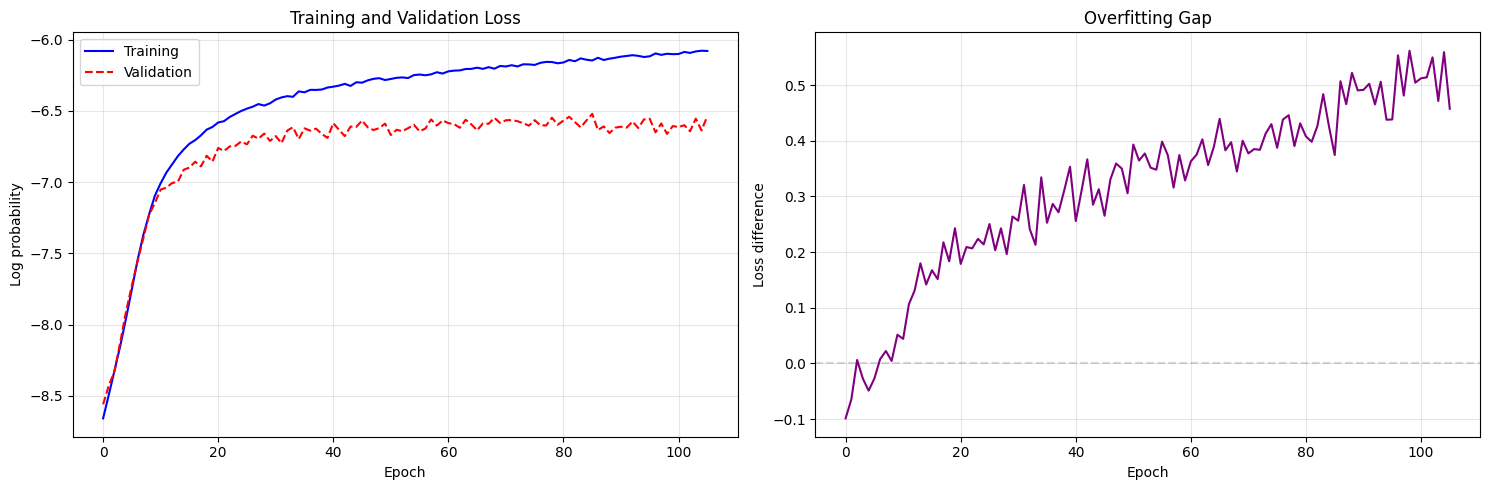

In [25]:
def plot_training_diagnostics(summaries):
    """Plot training diagnostics without empty subplots"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))  # Changed to 1 row, 2 columns
    
    # Loss curves
    train_losses = summaries[0]['training_log_probs']
    val_losses = summaries[0]['validation_log_probs']
    epochs = range(len(train_losses))
    
    ax1.plot(epochs, train_losses, '-', label='Training', color='blue')
    ax1.plot(epochs, val_losses, '--', label='Validation', color='red')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Log probability')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Overfitting gap
    gap = np.array(train_losses) - np.array(val_losses)
    ax2.plot(epochs, gap, '-', color='purple')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss difference')
    ax2.set_title('Overfitting Gap')
    ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Use the function
fig = plot_training_diagnostics(summaries)
plt.savefig(os.path.join(plots_out_dir, f'loss_overfitting_{model_params}.png'))
plt.show()
plt.close()

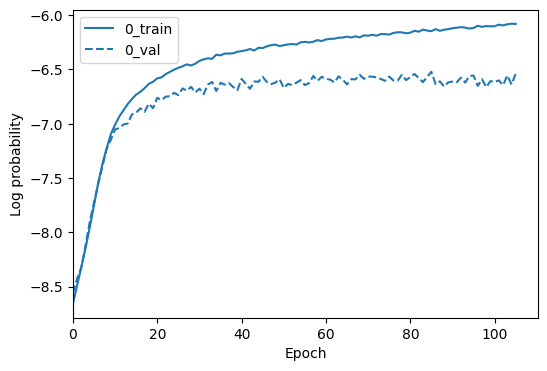

In [26]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

### Drawing samples from the entire test set to look at overall performance of the model

In [33]:
# Convert theta tensors to numpy for scaling
# convert to numpy
x_test = convert_to_numpy(x_test)
theta_test = convert_to_numpy(theta_test)

print(type(x_test))
print(type(theta_test))
# print(x_test.device)  # Should print something like 'cuda:0' if on GPU
# print(theta_test.device)  # Should print something like 'cuda:0' if on GPU

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [49]:
# Before any sampling, verify posterior is on correct device
if hasattr(posterior_ensemble, 'to'):
    posterior_ensemble = posterior_ensemble.to(device)
elif hasattr(posterior_ensemble, '_posterior') and hasattr(posterior_ensemble._posterior, 'to'):
    posterior_ensemble._posterior = posterior_ensemble._posterior.to(device)
else:
    print("Could not find a way to move posterior to device")

Could not find a way to move posterior to device


# DEBUGGING THE POSTERIOR DIRECTLY:

In [48]:
def test_posterior_sampling(posterior_ensemble, x_test, n_samples=1000):
    """Basic test of posterior sampling"""
    print("\nTesting posterior sampling...")
    
    # Try sampling from first test observation
    x_single = x_test[0:1]  # Take first observation
    
    try:
        # Sample directly from the posterior ensemble
        samples = posterior_ensemble.sample((n_samples,), x=x_single)
        
        print(f"Successfully drew {n_samples} samples")
        print(f"Samples shape: {samples.shape}")
        
        # Check sample ranges
        samples_np = samples.cpu().numpy()
        for i, param_name in enumerate(param_names):
            param_samples = samples_np[:, i]
            print(f"\n{param_name}:")
            print(f"Sample range: [{param_samples.min():.3f}, {param_samples.max():.3f}]")
            
            # Compare to prior range
            expected_min = df_info6.iloc[i]['MinVal']
            expected_max = df_info6.iloc[i]['MaxVal']
            print(f"Prior range: [{expected_min:.3f}, {expected_max:.3f}]")
            
            # Calculate what percentage of samples are within bounds
            in_bounds = ((param_samples >= expected_min) & (param_samples <= expected_max)).mean() * 100
            print(f"Percentage of samples within bounds: {in_bounds:.1f}%")
            
    except Exception as e:
        print(f"Error sampling from posterior: {e}")
        
# Test with a few different observation points
def test_multiple_observations(posterior_ensemble, x_test, theta_test, n_points=5):
    """Test sampling for multiple different observations"""
    print("\nTesting multiple observations...")
    
    for i in range(min(n_points, len(x_test))):
        print(f"\nTesting observation {i+1}:")
        x_single = x_test[i:i+1]
        theta_true = theta_test[i]
        
        try:
            # Try with fewer samples first
            samples = posterior_ensemble.sample((100,), x=x_single)
            
            # Calculate mean prediction
            mean_prediction = samples.mean(dim=0)
            
            # Compare to true values
            print("Parameter comparisons:")
            for j, param_name in enumerate(param_names):
                true_val = theta_true[j]
                pred_val = mean_prediction[j]
                print(f"{param_name}:")
                print(f"True: {true_val:.3f}")
                print(f"Predicted (mean): {pred_val:.3f}")
                
        except Exception as e:
            print(f"Error: {e}")

# Also let's check the neural network directly
def inspect_posterior_net(posterior_ensemble):
    """Inspect the neural posterior network"""
    print("\nInspecting posterior network...")
    
    try:
        # Get the first network in the ensemble
        net = posterior_ensemble.net
        
        # Print network info
        print(f"Network type: {type(net)}")
        print(f"Network parameters: {sum(p.numel() for p in net.parameters())}")
        
        # Try to get embedding dimensions
        try:
            print(f"Input dimension: {net.input_dim}")
            print(f"Context dimension: {net.context_dim}")
        except:
            print("Could not access network dimensions")
            
    except Exception as e:
        print(f"Error inspecting network: {e}")

# Run all tests
test_posterior_sampling(posterior_ensemble, x_test)
test_multiple_observations(posterior_ensemble, x_test, theta_test)
inspect_posterior_net(posterior_ensemble)


Testing posterior sampling...


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Error sampling from posterior: Expected all tensors to be on the same device, but found at least two devices, cuda:2 and cpu!

Testing multiple observations...

Testing observation 1:


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Error: Expected all tensors to be on the same device, but found at least two devices, cuda:2 and cpu!

Testing observation 2:


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Error: Expected all tensors to be on the same device, but found at least two devices, cuda:2 and cpu!

Testing observation 3:


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Error: Expected all tensors to be on the same device, but found at least two devices, cuda:2 and cpu!

Testing observation 4:


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Error: Expected all tensors to be on the same device, but found at least two devices, cuda:2 and cpu!

Testing observation 5:


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Error: Expected all tensors to be on the same device, but found at least two devices, cuda:2 and cpu!

Inspecting posterior network...
Error inspecting network: 'NeuralPosteriorEnsemble' object has no attribute 'net'


In [34]:
metric = PosteriorCoverage(
    num_samples=int(4e3),
    sample_method='direct',
    # sample_method="slice_np_vectorized",
    # sample_params={'num_chains': 1},
    # sample_method="vi",
    # sample_params={"dist": "maf", "n_particles": 32, "learning_rate": 1e-2},
    labels=cam.labels,
    plot_list=["coverage", "histogram", "predictions", "tarp"],
    # out_dir="../plots/",
)

fig = metric(
    posterior=posterior_ensemble,
    x=x_test, #on CPU
    theta=theta_test, # on CPU
    signature=f"coverage_{name}_",
)

                    accepted. It may take a long time to collect the remaining
                    4000 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.
  0%|          | 0/1845 [02:44<?, ?it/s]


KeyboardInterrupt: 

In [29]:
# # After scaling, convert to torch tensors with correct dtype
# x_test = torch.tensor(x_test, dtype=torch.float32, device=device)
# theta_test = torch.tensor(theta_test, dtype=torch.float32, device=device)


In [32]:

print(type(x_test))
print(type(theta_test))
print(x_test.device)  # Should print something like 'cuda:0' if on GPU
print(theta_test.device)  # Should print something like 'cuda:0' if on GPU

<class 'torch.Tensor'>
<class 'torch.Tensor'>
cuda:2
cuda:2


In [28]:
# Drawing samples from the ensemble posterior

metric = PosteriorCoverage(
    num_samples=1000, sample_method='direct', 
    labels=[f'$\\theta_{i}$' for i in range(3)],
    plot_list = ["coverage", "histogram", "predictions", "tarp", "logprob"],
    out_dir=None
)

fig = metric(
    posterior=posterior_ensemble, # NeuralPosteriorEnsemble instance from sbi package
    x=x_test, theta=theta_test
)

  0%|          | 0/1845 [00:00<?, ?it/s]WARNING:root:Only 0.000% proposal samples are
                    accepted. It may take a long time to collect the remaining
                    1000 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.
  0%|          | 0/1845 [00:14<?, ?it/s]


KeyboardInterrupt: 

In [29]:
# Ensure x_test and theta_test are properly converted to tensors on GPU
if not torch.is_tensor(x_test):
    x_test = torch.tensor(x_test, dtype=torch.float32, device=device)
if not torch.is_tensor(theta_test):
    theta_test = torch.tensor(theta_test, dtype=torch.float32, device=device)

# Number of samples to draw from posterior
n_samples = 1000

# Storage for predictions
all_samples = []
all_means = []
all_stds = []

# Suppress the deprecation warning
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='nflows.transforms.lu')

# Set MCMC as default sampler for all posteriors in the ensemble
for posterior in posterior_ensemble.posteriors:
    posterior._sample_with = 'mcmc'  # Set MCMC as default sampler

# Generate posterior samples for each test point one at a time
for i in range(len(x_test)):
    with torch.no_grad():
        x_i = x_test[i:i+1]
        
        # Sample using the ensemble (now with MCMC by default)
        samples = posterior_ensemble.sample(
            (n_samples,), 
            x=x_i
        )
        samples_np = samples.cpu().numpy()
    
    # Calculate statistics in numpy for efficiency
    mean = samples_np.mean(axis=0)
    std = samples_np.std(axis=0)
    
    all_samples.append(samples_np)
    all_means.append(mean)
    all_stds.append(std)

    # Print progress
    if (i + 1) % 10 == 0:
        print(f"Processed {i+1}/{len(x_test)} test points")

# Convert lists to numpy arrays
all_samples = np.array(all_samples)
all_means = np.array(all_means)
all_stds = np.array(all_stds)

print("Samples shape:", all_samples.shape)
print("Means shape:", all_means.shape)
print("Stds shape:", all_stds.shape)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

                    accepted. It may take a long time to collect the remaining
                    1000 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.


KeyboardInterrupt: 

In [ ]:

# # Number of samples to draw from posterior
# n_samples = 1000

# # Storage for predictions
# all_samples = []
# all_means = []
# all_stds = []

# # Suppress the deprecation warning
# import warnings
# warnings.filterwarnings('ignore', category=UserWarning, module='nflows.transforms.lu')

# # Generate posterior samples for each test point
# for i in range(len(x_test)):
#     # Get samples from the posterior
#     with torch.no_grad():  # Add this for efficiency
#         samples = posterior_ensemble.sample(
#             (n_samples,), 
#             x=x_test[i].reshape(1, -1)
#         ).cpu().numpy()
    
#     # Calculate mean and std of samples
#     mean = samples.mean(axis=0)
#     std = samples.std(axis=0)
    
#     all_samples.append(samples)
#     all_means.append(mean)
#     all_stds.append(std)

# all_samples = np.array(all_samples)
# all_means = np.array(all_means)
# all_stds = np.array(all_stds)

In [ ]:
param_names = df_pars.columns[1:29].tolist()  # Excluding 'name' column

fig, axes = plt.subplots(7, 4, figsize=(16, 28)) 
axes = axes.flatten()

fontsize = 10  

plt.rcParams['figure.constrained_layout.use'] = True  

# Plot each parameter
for i in range(28):
    ax = axes[i]
    
    # True vs predicted with error bars
    ax.errorbar(
        theta_test[:, i].cpu().numpy(),
        all_means[:, i],
        yerr=all_stds[:, i],
        fmt='.',
        color='k',
        ecolor='blue',
        capsize=0,
        elinewidth=0.8,  
        alpha=0.3,       
        markersize=5    
    )
    
    # Add true line
    lims = [
        min(ax.get_xlim()[0], ax.get_ylim()[0]),
        max(ax.get_xlim()[1], ax.get_ylim()[1])
    ]
    ax.plot(lims, lims, '--', color='black', alpha=0.5, linewidth=1)
    
    # get metrics
    rmse = np.sqrt(np.mean((theta_test[:, i].cpu().numpy() - all_means[:, i])**2))
    r2 = np.corrcoef(theta_test[:, i].cpu().numpy(), all_means[:, i])[0, 1]**2
    chi2 = np.mean(((theta_test[:, i].cpu().numpy() - all_means[:, i])**2) / (all_stds[:, i]**2))
    
    # add metrics box in top left corner
    stats_text = f'RMSE = {rmse:.2f}\n' + \
                 f'R² = {r2:.2f}\n' + \
                 f'χ² = {chi2:.2f}'
    ax.text(0.05, 0.95, stats_text,
            transform=ax.transAxes,
            bbox=dict(facecolor='white', alpha=0.8),
            verticalalignment='top',
            fontsize=fontsize-1)  # Slightly smaller font for stats
    
    # title: parameter name
    ax.set_title(param_names[i], fontsize=fontsize, pad=5)  # Reduced padding
    
    # axis labels
    ax.set_xlabel('True', fontsize=fontsize-1)
    ax.set_ylabel('Inferred', fontsize=fontsize-1)
    
    # tick labels
    ax.tick_params(axis='both', which='major', labelsize=fontsize-2)
    
    # internal padding
    ax.margins(x=0.05, y=0.05)

# subplot spacing
plt.subplots_adjust(
    left=0.01,    # Less space on left
    right=0.7,   # Less space on right
    bottom=0.05,  # Less space at bottom
    top=0.7,     # Less space at top
    wspace=0.2,   # Less space between plots horizontally
    hspace=0.2    # Less space between plots vertically
)


# Save figure with detailed filename
save_path = f'{plots_out_dir}/posterior_predictions_{model_params}.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0.1)
print(save_path)
plt.show()

In [ ]:
config_str = (f"batch{train_args['training_batch_size']}_"
             f"lr{train_args['learning_rate']}_"
             f"epochs{train_args['stop_after_epochs']}_"
             f"h{hidden_features}_t{num_transforms}")

# coverage plots
metric = PosteriorCoverage(
    num_samples=int(4e3),
    sample_method='direct',
    labels=cam.labels,
    plot_list=["tarp"], # "coverage", "histogram", "predictions", 
    out_dir=plots_out_dir,
)

# Generate plots
figs = metric(
    posterior=posterior_ensemble,
    x = x_test,
    theta = theta_test,
    # x=x_all[test_mask].cpu(),
    # theta=theta[test_mask, :].cpu(),
    signature=f"coverage_{name}_{config_str}_"  # Add config to filename
)

config_text = (
    f"Training Config:\n"
    f"Batch Size: {train_args['training_batch_size']}\n"
    f"Learning Rate: {train_args['learning_rate']}\n"
    f"Epochs: {train_args['stop_after_epochs']}\n"
    f"Hidden Features: {hidden_features}\n"
    f"Num Transforms: {num_transforms}"
)

# Process each figure
for i, fig in enumerate(figs):
    plt.figure(fig.number)  # Activate the figure
    plt.figtext(0.02, 0.98, config_text,
                fontsize=8,
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'),
                verticalalignment='top')
    
    # Save each figure with type indicator
    plot_types = ["tarp"] #"coverage", "histogram", "predictions",
    plt.savefig(os.path.join(plots_out_dir, 
                f'metric_{plot_types[i]}_{name}_{config_str}.png'), 
                dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

In [ ]:
def get_performance_metric(summaries, posterior):
    # Get validation loss at convergence
    final_val_loss = summaries[0]['validation_log_probs'][-1]
    
    # Get average RMSE across parameters
    rmse_vals = [
        np.sqrt(np.mean((theta_test[:, i].cpu().numpy() - all_means[:, i])**2))
        for i in range(len(param_names))
    ]
    avg_rmse = np.mean(rmse_vals)
    
    # Get average R² across parameters  
    r2_vals = [
        np.corrcoef(theta_test[:, i].cpu().numpy(), all_means[:, i])[0, 1]**2 
        for i in range(len(param_names))
    ]
    avg_r2 = np.mean(r2_vals)

    # Composite score (lower is better)
    # Weighting validation loss more heavily since it's key for convergence
    composite_score = -final_val_loss + avg_rmse - avg_r2

    return {
        'composite_score': composite_score,
        'val_loss': final_val_loss,
        'avg_rmse': avg_rmse,
        'avg_r2': avg_r2
    }

results = {
    'architecture': {
        'hidden_features': hidden_features,
        'num_transforms': num_transforms,
        'num_nets': num_nets
    },
    'training': {
        'batch_size': train_args['training_batch_size'],
        'learning_rate': train_args['learning_rate'],
        'epochs': train_args['stop_after_epochs']
    },
    'performance': get_performance_metric(summaries, posterior_ensemble)
}

# Flatten the nested dictionary into a single level
flat_results = {
   'hidden_features': results['architecture']['hidden_features'],
   'num_transforms': results['architecture']['num_transforms'], 
   'num_nets': results['architecture']['num_nets'],
   'batch_size': results['training']['batch_size'],
   'learning_rate': results['training']['learning_rate'],
   'epochs': results['training']['epochs'],
   'composite_score': results['performance']['composite_score'],
   'val_loss': results['performance']['val_loss'],
   'avg_rmse': results['performance']['avg_rmse'], 
   'avg_r2': results['performance']['avg_r2']
}

# Create DataFrame with single row
df = pd.DataFrame([flat_results])

# Improve formatting
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(df.to_string(index=False))

In [86]:
import os

def save_results(results):
   flat_results = {
       'hidden_features': results['architecture']['hidden_features'],
       'num_transforms': results['architecture']['num_transforms'], 
       'num_nets': results['architecture']['num_nets'],
       'batch_size': results['training']['batch_size'],
       'learning_rate': results['training']['learning_rate'],
       'epochs': results['training']['epochs'],
       'composite_score': results['performance']['composite_score'],
       'val_loss': results['performance']['val_loss'],
       'avg_rmse': results['performance']['avg_rmse'],
       'avg_r2': results['performance']['avg_r2']
   }
   
   df_row = pd.DataFrame([flat_results])
   
   if os.path.exists('sbi_results_norm.csv'):
       df_row.to_csv('sbi_results_norm.csv', mode='a', header=False, index=False)
   else:
       df_row.to_csv('sbi_results_norm.csv', index=False)
       
save_results(results)

The composite score weights validation loss more heavily since it's crucial for the model's predictive performance. Lower composite scores indicate better overall performance.